<a href="https://colab.research.google.com/github/aminfadaei116/Deep-Learning-Course/blob/master/CA4/Part1_edu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


At the start you need to add the file in local part of the google colab


In [ ]:
!pip install torchaudio
import cv2
from scipy.io import loadmat
import numpy as np
import tqdm
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linalg as LA
import re
from load_data import load_data
from load_data2 import load_data2
from tqdm.notebook import tqdm
import json
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# makes it easy to write user-friendly command-line interfaces
import argparse
# contains data structures for multi-dimensional tensors
# and mathematical operations over theme
import torch
# helps us in creating and training of the neural network.
import torch.nn as nn
# contains all the functions in the torch.nn library
import torch.nn.functional as F
# implements various optimization algorithms
import torch.optim as optim
# contains datasets with almost similar API
from torchvision import datasets
# contains common image transformations
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# provides several methods to adjust the learning rate based on the number of epochs
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
import math

The Functions that are needed

In [ ]:
PAD_CHAR = "¶"
SOS_CHAR = "§"
EOS_CHAR = "¤"
!pip install python-Levenshtein
import Levenshtein as Lev

def cer(real, pred):
  real, pred, = real.replace(' ', ''), pred.replace(' ', '')
  return Lev.distance(real, pred) / len(real)
  
# used the link https://holianh.github.io/portfolio/Cach-tinh-WER/ for this function
def wer(real, pred):
    r = real.split()
    h = pred.split()
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3
    DEL_PENALTY=1 
    INS_PENALTY=1
    SUB_PENALTY=1 
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL

    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS

    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY 
                insertionCost    = costs[i][j-1] + INS_PENALTY   
                deletionCost     = costs[i-1][j] + DEL_PENALTY   

                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL

    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
    return (numSub + numDel + numIns) / (float) (len(r))

def print_label(code_number):
  for i, sentence in enumerate(code_number):
    text = []
    pre_char = ""
    for charec in sentence:
      temp = id2label.get(charec.item())
      if temp in [PAD_CHAR, SOS_CHAR, EOS_CHAR]:
        continue
      elif pre_char == temp:
        continue
      else:
        text.append(temp)
        pre_char = temp
    result = ''.join(text)
    print(result)

def print_result(output):
  outscore = torch.exp(output)
  outscore = outscore.permute(0, 2, 1)
  state = torch.argmax(outscore, dim=1)
  result = ""
  for i, sentence in enumerate(state):
    text = []
    pre_char = ""
    for charec in sentence:
      temp = id2label.get(charec.item())
      if temp in [PAD_CHAR, SOS_CHAR, EOS_CHAR]:
        continue
      elif pre_char == temp:
        continue
      else:
        text.append(temp)
        pre_char = temp
    txt_tmp = ''.join(text)
    print(txt_tmp)
    result += txt_tmp
    result += "\n"
  return result

def calc_cer(output, code_number):
  outscore = torch.exp(output)
  outscore = outscore.permute(0, 2, 1)
  state_out = torch.argmax(outscore, dim=1)
  cerlst = []
  werlst = []
  for i in range(12):
    text_out = []
    text_lbl = []
    pre_char = ""
    for charec in state_out[i]:
      temp = id2label.get(charec.item())
      if temp in [PAD_CHAR, SOS_CHAR, EOS_CHAR]:
        continue
      elif pre_char == temp:
        continue
      else:
        text_out.append(temp)
        pre_char = temp
    predtxt = ''.join(text_out)
    pre_char = ""
    for charec in code_number[i]:
      temp = id2label.get(charec.item())
      if temp in [PAD_CHAR, SOS_CHAR, EOS_CHAR]:
        continue
      elif pre_char == temp:
        continue
      else:
        text_lbl.append(temp)
        pre_char = temp
    realtxt = ''.join(text_lbl)
    cerlst.append(cer(realtxt, predtxt))
    werlst.append(wer(realtxt, predtxt))
    del realtxt
    del predtxt
  return (sum(cerlst)/len(cerlst)), (sum(werlst)/len(werlst))



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
val_data = pd.read_csv("/content/drive/My Drive/Academics/Deep Learning/DataSet/data_val.csv", header = None)
test_data = pd.read_csv("/content/drive/My Drive/Academics/Deep Learning/DataSet/data_test.csv", header = None)
train_data = pd.read_csv("/content/drive/My Drive/Academics/Deep Learning/DataSet/data_train.csv", header = None)
#new_train_data = pd.read_csv("/content/drive/My Drive/Academics/Deep Learning/DataSet/new_data_train.csv", header = None)

In [ ]:
del val_data
del test_data
del train_data

In [ ]:
!python3 -m pip install --user --upgrade pip

!export PATH="/root/.local/bin:$PATH"

!python3 -m pip --version

!apt-get install python3-venv

!python3 -m venv env

!source env/bin/activate

!source env/bin/activate; which python

!source env/bin/activate; pip install -r req.txt


!source env/bin/activate; bash download_prepare_data.sh


#!zip -r data.zip data

#!cp -av data.zip "/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW4-Dataset/"



In [ ]:
import os
df = pd.read_csv('data_train.csv', header = None)
temp = []
for idx, row in df.iterrows():
  isFile1 = os.path.isfile(row[0])
  isFile2 = os.path.isfile(row[1]) 
  if isFile1 == False:
    temp.append(idx)
  elif isFile2 == False:
    temp.append(idx)
clean_train_data = df.drop(temp)

In [ ]:
for idx, row in clean_train_data.iterrows():
  isFile1 = os.path.isfile(row[0])
  isFile2 = os.path.isfile(row[1]) 
  if isFile1 == False:
    print(idx)
  elif isFile2 == False:
    print(idx)


In [ ]:
clean_train_data.to_csv('/content/clean_train_data.csv', header=None, index=None)

In [ ]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/content/drive/My Drive/Academics/Deep Learning/DataSet/data.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

In [ ]:
%cp -av "/content/drive/My Drive/Academics/Deep Learning/DataSet/data_val.csv" "/content"
%cp -av "/content/drive/My Drive/Academics/Deep Learning/DataSet/data_test.csv" "/content"
%cp -av "/content/drive/My Drive/Academics/Deep Learning/DataSet/data_train.csv" "/content"
#%cp -av "/content/drive/My Drive/Academics/Deep Learning/DataSet/new_data_train.csv" "/content"


In [ ]:
train_loader, val_loader, test_loader, label2id, id2label = load_data2(['clean_train_data.csv'],['data_val.csv'],['data_test.csv'])

done !


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, dim_model, dim_key, dim_value, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.dim_model = dim_model
    self.dim_key = dim_key
    self.dim_value = dim_value
    self.query_linear = nn.Linear(in_features=dim_model, out_features=num_heads * dim_key)
    self.key_linear = nn.Linear(in_features=dim_model, out_features=num_heads * dim_key)
    self.value_linear = nn.Linear(in_features=dim_model, out_features=num_heads * dim_value)
    self.Attention = ScaledDotProductAttention(np.power(dim_key, 0.5), dropout=dropout)
    self.layer_norm = nn.LayerNorm(dim_model, eps=1e-5)
    self.output_linear = nn.Linear(in_features=num_heads * dim_value, out_features=dim_model)
    self.D1 = nn.Dropout(dropout)

  def forward(self, query, key, value):
    batch_size, query_len, _ = query.size()
    batch_size, key_len, _ = key.size()
    batch_size, value_len, _ = value.size()
    first_query = query
    query = self.query_linear(query).view(batch_size, query_len, self.num_heads, self.dim_key) 
    key = self.key_linear(key).view(batch_size, key_len, self.num_heads, self.dim_key) 
    value = self.value_linear(value).view(batch_size, value_len, self.num_heads, self.dim_value) 
    query = query.permute(2, 0, 1, 3).contiguous().view(-1, query_len, self.dim_key) 
    key = key.permute(2, 0, 1, 3).contiguous().view(-1, key_len, self.dim_key) 
    value = value.permute(2, 0, 1, 3).contiguous().view(-1, value_len, self.dim_value) 
    output = self.Attention(query, key, value)
    output = output.view(self.num_heads, batch_size, query_len, self.dim_value) 
    output = output.permute(1, 2, 0, 3).contiguous().view(batch_size, query_len, -1) 
    output = self.D1(self.output_linear(output)) 
    output = self.layer_norm(output + first_query)
    return output

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, temp, dropout=0.1):
    super().__init__()
    self.temp = temp
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim=2)

  def forward(self, query, key, value):
    attention = torch.bmm(query, key.transpose(1, 2))
    attention = attention / self.temp
    attention = self.dropout(self.softmax(attention))
    output = torch.bmm(attention, value)
    return output

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim_model, max_length=2100):
    super(PositionalEncoding, self).__init__()
    Position_Encoded = torch.zeros(max_length, dim_model)
    pos = torch.arange(0, max_length).unsqueeze(1).float()
    direr = np.power(0.0001, torch.arange(0, dim_model, 2).float()/dim_model)
    Position_Encoded[:, 1::2] = torch.cos(pos * direr)
    Position_Encoded[:, 0::2] = torch.sin(pos * direr)
    Position_Encoded = Position_Encoded.unsqueeze(0)
    self.register_buffer('Position_Encoded', Position_Encoded)

  def forward(self, input):
    return self.Position_Encoded[:, :input.size(1)]

In [ ]:
class PositionwiseFeedForwardWithConv(nn.Module):
  def __init__(self, dim_model, dim_inner, dropout=0.1):
    super(PositionwiseFeedForwardWithConv, self).__init__()
    self.conv1 = nn.Conv1d(dim_model, dim_inner, kernel_size=(1,), stride=(1,))
    self.conv2 = nn.Conv1d(dim_inner, dim_model, kernel_size=(1,), stride=(1,))
    self.D1 = nn.Dropout(dropout)
    self.LN1 = nn.LayerNorm(dim_model)

  def forward(self, position_input):
    output = position_input.transpose(1, 2)
    output = self.conv1(output)
    output = self.conv2(F.relu(output))
    output = output.transpose(1, 2)
    output = self.D1(output)
    output = self.LN1(output + position_input)
    return output

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, num_heads, dim_model, dim_inner, dim_key, dim_value, dropout=0.1):
    super(EncoderLayer, self).__init__()
    self.Self_Attention = MultiHeadAttention(num_heads, dim_model, dim_key, dim_value, dropout=dropout)
    self.POSS_FNN = PositionwiseFeedForwardWithConv(dim_model, dim_inner, dropout=dropout)

  def forward(self, encoder_input):
    encoder_output = self.Self_Attention(encoder_input, encoder_input, encoder_input)
    encoder_output = self.POSS_FNN(encoder_output)
    return encoder_output

In [ ]:
class Encoder(nn.Module):
  def __init__(self, num_layers, num_heads, dim_model, dim_key, dim_value, dim_input, dim_inner, dropout=0.1, max_leng=1900):
    super(Encoder, self).__init__()
    self.D1 = nn.Dropout(dropout, inplace=False)
    self.L1 = nn.Linear(in_features=dim_input, out_features=dim_model)
    self.LN1 = nn.LayerNorm(dim_model, eps=1e-5)
    self.PE = PositionalEncoding(dim_model, max_leng)
    self.Multi_layers = nn.ModuleList([EncoderLayer(num_heads, dim_model, dim_inner, dim_key, dim_value, dropout=dropout) for _ in range(num_layers)])

  def forward(self, encoder_input, input_lengths):
    encoder_input = self.D1(encoder_input)
    encoder_output = self.LN1(self.L1(encoder_input)) + self.PE(encoder_input) #according to the paper we need to add it as well
    for layer in self.Multi_layers:
      encoder_output = layer(encoder_output)
    return encoder_output

In [ ]:
class HW4_Tansformer(nn.Module):
  def __init__(self, encoder, dim_model, dim_output):
    super(HW4_Tansformer, self).__init__()
    self.encoder = encoder
    self.conv1 = nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
    self.bn1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1)
    self.ht1 = nn.Hardtanh(0, 20)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
    self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1)
    self.ht2 = nn.Hardtanh(0, 20)
    self.output_linear = nn.Linear(dim_model, dim_output)
    self.unlinear_layer = nn.LogSoftmax(dim=2)
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def forward(self, padded_input2, input_lengths, padded_target):
    ## thsi part is for embedding
    output = self.conv1(padded_input2)
    output = self.bn1(output)
    output = self.ht1(output)
    output = self.conv2(output)
    output = self.bn2(output)
    output = self.ht2(output)
    padded_input = output
    ### this part is changing the dimension
    dimensions = padded_input.size()
    padded_input = padded_input.view(dimensions[0], dimensions[1] * dimensions[2], dimensions[3])
    padded_input = padded_input.transpose(1, 2).contiguous()
    ## this part is for the encoding part
    encoder_padded_outputs = self.encoder(padded_input, input_lengths)
    ## and we need to add some final layers for the model
    encoder_padded_outputs = self.output_linear(encoder_padded_outputs)
    encoder_padded_outputs = self.unlinear_layer(encoder_padded_outputs)
    return encoder_padded_outputs
    

In [ ]:
train_loss = []
val_loss = []
train_cer = []
val_cer = []
train_wer = []
val_wer = []
main_txt = ""

In [ ]:
def Train_NetWork(model, epoch_number, d_model, warm_up, train_loss, val_loss, train_cer, val_cer, train_wer, val_wer, main_txt):
  model.train()
  step_num = 0
  ctc_loss = nn.CTCLoss()
  temp = np.power(d_model, -1/2)
  temp_warm = np.power(warm_up, -3/2)
  Val_idx = [i for i in range(0,4)]

  for epoch in range(epoch_number):
    in_step = 0
    loss_val = []
    cer_var = []
    wer_var = []
    The_Test = 4812
    for i, (inputs, labels, input_percent, input_size, label_size) in enumerate(train_loader):
      
      if input_size[0] > 1000: #if there something gets too big we continue
        continue
      learning_rate = temp * np.minimum(np.power(step_num + 1, -1/2), (step_num + 1) * temp_warm)
      optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-09)
      inputs = inputs.to(device)
      input_size = input_size.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output2 = model.forward(inputs, input_size, labels)
      loss = F.ctc_loss(output2.permute(1,0,2), labels, ((input_size - 9)/2), label_size)
      if in_step == The_Test:
        main_txt += print_result(output2)
      if in_step % 500 == 0:
        train_loss.append(loss.cpu())
        cer_tmp, wer_tmp = calc_cer(output2, labels)
        train_cer.append(cer_tmp)
        train_wer.append(wer_tmp)
      if in_step in Val_idx:
        loss_val.append(loss.cpu())
        cer_tmp, wer_tmp = calc_cer(output2, labels)
        cer_var.append(cer_tmp)
        wer_var.append(wer_tmp)
        del cer_tmp
        del wer_tmp
        del inputs
        del input_size
        del labels
        step_num += 1
        in_step += 1
        continue
      del inputs
      del input_size
      del labels
      loss.backward()
      optimizer.step()
      print("epoch: ", epoch, "iteration: ", (step_num + 1), "step of epoch", in_step,  " loss for batch: ", loss, "lr: ", learning_rate)
      step_num += 1
      in_step += 1
    val_loss.append(sum(loss_val)/len(loss_val))
    val_cer.append(sum(cer_var)/len(cer_var))
    val_wer.append(sum(wer_var)/len(wer_var))
    del loss_val
    del cer_var
    del wer_var
  return train_loss, val_loss, train_cer, val_cer, train_wer, val_wer, main_txt



  

In [ ]:
train_loss = []
val_loss = []
train_cer = []
val_cer = []
train_wer = []
val_wer = []
main_txt = ""

In [ ]:
sample_rate = 16000
window_size = 0.02
hidden_size = int(math.floor( (sample_rate * window_size) / 2) + 1)
hidden_size = int(math.floor(hidden_size - 41) / 2 + 1)
hidden_size = int(math.floor(hidden_size - 21) / 2 + 1)

MyEncoder = Encoder(num_layers=4, num_heads=8, dim_model=256, dim_key=64, dim_value=64, dim_input=hidden_size*32,  dim_inner=1024)
MyNetWork = HW4_Tansformer(MyEncoder, dim_model=256, dim_output=32)
MyNetWork.to(device)

In [ ]:
train_loss, val_loss, train_cer, val_cer, train_wer, val_wer, main_txt = Train_NetWork(MyNetWork, 3, 512, 4000, train_loss, val_loss, train_cer, val_cer, train_wer, val_wer, main_txt)

In [ ]:
print(train_loss)
print(val_loss)
print(train_cer)
print(val_cer)
print(train_wer)
print(val_wer)
print(main_txt)

In [ ]:
num = "7"
torch.save(train_loss, '/content/drive/My Drive/Academics/Deep Learning/DataSet/Loss/train_loss' + num + '.pt')
torch.save(val_loss, '/content/drive/My Drive/Academics/Deep Learning/DataSet/Loss/val_loss' + num + '.pt')
torch.save(train_cer, '/content/drive/My Drive/Academics/Deep Learning/DataSet/CER/train_cer' + num + '.pt')
torch.save(val_cer, '/content/drive/My Drive/Academics/Deep Learning/DataSet/CER/val_cer' + num + '.pt')
torch.save(train_wer, '/content/drive/My Drive/Academics/Deep Learning/DataSet/WER/train_wer' + num + '.pt')
torch.save(val_wer, '/content/drive/My Drive/Academics/Deep Learning/DataSet/WER/val_wer' + num + '.pt')

text_file = open('/content/drive/My Drive/Academics/Deep Learning/DataSet/Text/main' + num + '.txt', "w")
n = text_file.write(main_txt)
text_file.close()

In [ ]:
torch.save(MyNetWork.state_dict(), "/content/drive/My Drive/Academics/Deep Learning/DataSet/Model/model_ep" + num + ".pt")

In [ ]:
num = "7"
train_loss = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/Loss/train_loss' + num + '.pt')
val_loss = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/Loss/val_loss' + num + '.pt')
train_cer = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/CER/train_cer' + num + '.pt')
val_cer = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/CER/val_cer' + num + '.pt')
train_wer = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/WER/train_wer' + num + '.pt')
val_wer = torch.load('/content/drive/My Drive/Academics/Deep Learning/DataSet/WER/val_wer' + num + '.pt')

file = open('/content/drive/My Drive/Academics/Deep Learning/DataSet/Text/main' + num + '.txt')
main_txt = file.read()
file.close()

In [ ]:

MyNetWork.load_state_dict(torch.load("/content/drive/My Drive/Academics/Deep Learning/DataSet/Model/model_ep" + num + ".pt"))
#torch.load('file.pt')

<All keys matched successfully>

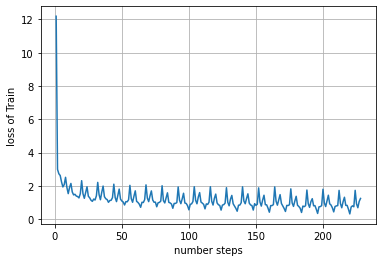

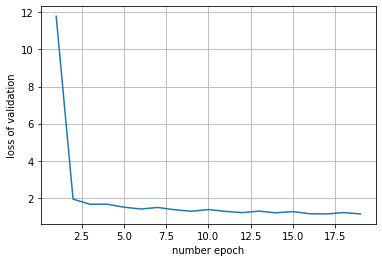

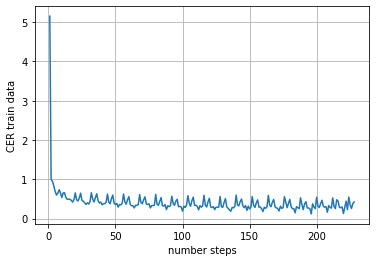

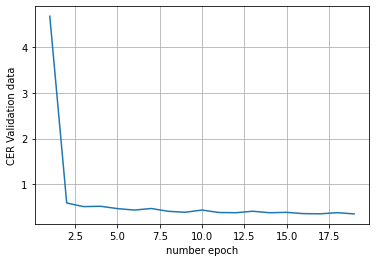

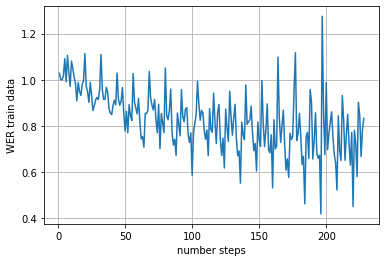

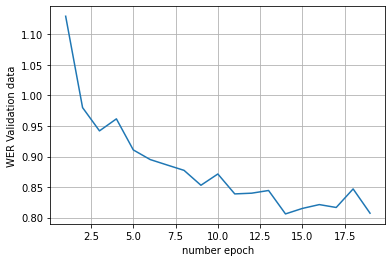

In [ ]:
def plot_acc(train_loss, val_loss, train_cer, val_cer, train_wer, val_wer):
  plt.plot(np.arange(1,len(train_loss)+1), train_loss)
  plt.ylabel('loss of Train')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(val_loss)+1), val_loss)
  plt.ylabel('loss of validation')
  plt.xlabel("number epoch")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(train_cer)+1), train_cer)
  plt.ylabel('CER train data')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(val_cer)+1), val_cer)
  plt.ylabel('CER Validation data')
  plt.xlabel("number epoch")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(train_wer)+1), train_wer)
  plt.ylabel('WER train data')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(val_wer)+1), val_wer)
  plt.ylabel('WER Validation data')
  plt.xlabel("number epoch")
  plt.grid(True)
  plt.show()

plot_acc(train_loss, val_loss, train_cer, val_cer, train_wer, val_wer)


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()